# Totalvi differential expression testing

### General summary notes:
- Run totalvi first - This is annotation independent
- Save totalvi outputs independently
- Read in annotation metadata
- Compute totalvi differential expression (DE) using updated metadata
- Read in DSB GMM corrected protein counts
- Calculate dendrogam using vae model
- Generate plot using degs derived from totalvi DE test

### Totalvi integration to generate model

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
 
import scvi
import scanpy as sc

In [ ]:
RNA = sc.read('/home/jupyter/mount/sanger_gdrive/YS/totalvi_review_1/YS_and_Liver_combined/YS_Liver_CITEseq_RNA_raw_modality_intersect_20220927.h5ad')
Protein = sc.read('/home/jupyter/mount/sanger_gdrive/YS/totalvi_review_1/YS_and_Liver_combined/YS_Liver_CITEseq_Protein_raw_modality_intersect_20220927.h5ad')

In [ ]:
RNA = RNA[RNA.obs['Organ'].isin(['YS'])]
Protein = Protein[Protein.obs['Organ'].isin(['YS'])]

In [ ]:
adata1 = RNA.copy()

In [ ]:
adata1.obsm['protein_expression'] = pd.DataFrame.sparse.from_spmatrix(Protein.X, index=Protein.obs.index, columns=Protein.var.index)

adata1.layers["counts"] = adata1.X.copy()
sc.pp.normalize_total(adata1, target_sum=1e4)
sc.pp.log1p(adata1)
adata1.raw = adata1

In [ ]:
adata1

In [ ]:
sc.pp.highly_variable_genes(
    adata1,
    n_top_genes=4000,
    #flavor="seurat",
    flavor="seurat_v3",
    batch_key="identifier",
    subset=True,
    layer="counts"
)

In [ ]:
adata = adata1.copy()

In [ ]:
scvi.model.TOTALVI.setup_anndata(
    adata,
    protein_expression_obsm_key="protein_expression",
    layer="counts",
    batch_key="identifier",
    #categorical_covariate_keys = ['Organ']
)

In [ ]:
vae = scvi.model.TOTALVI(adata, latent_distribution="normal")

In [ ]:
vae.train()

In [ ]:
adata.obsm["X_totalVI"] = vae.get_latent_representation()

rna, protein = vae.get_normalized_expression(
    n_samples=25,
    return_mean=True,
    transform_batch=list(adata.obs['identifier'].unique())
)

adata.layers["denoised_rna"], adata.obsm["denoised_protein"] = rna, protein

adata.obsm["protein_foreground_prob"] = vae.get_protein_foreground_probability(
    n_samples=25,
    return_mean=True,
    transform_batch=list(adata.obs['identifier'].unique())
)
parsed_protein_names = [p.split("_")[0] for p in adata.obsm["protein_expression"].columns]
adata.obsm["protein_foreground_prob"].columns = parsed_protein_names

In [ ]:
sc.pp.neighbors(adata, use_rep="X_totalVI")
sc.tl.umap(adata)

### Save totalvi outputs

- Save independently as can't save object post totalvi integration

In [ ]:
vae.save("./totalvi_model_run_YS_20220928/")

In [ ]:
adata.obs.to_csv('./obs_for_totalvi_model_run_YS_20220928.csv')

In [ ]:
np.savetxt("./latent_X_totalVI_for_totalvi_model_run_YS_20220928.csv", adata.obsm['X_totalVI'], delimiter=",")

In [ ]:
adata.var.to_csv('./var_for_totalvi_model_run_YS_20220928.csv')

In [ ]:
np.savetxt("./totalvi_umap_for_totalvi_model_run_YS_20220928.csv", adata.obsm['X_umap'], delimiter=",")

In [ ]:
adata.obsm['denoised_protein'].to_csv('./denoised_protein_for_totalvi_model_run_YS_20220928.csv')

In [ ]:
adata.obsm['protein_foreground_prob'].to_csv('./protein_foreground_prob_for_totalvi_model_run_YS_20220928.csv')

In [ ]:
np.savetxt("./denoised_rna_for_totalvi_model_run_YS_20220928.csv", adata.layers['denoised_rna'], delimiter=",")

### Totalvi deg calculation

- Read in previously saved vae model 
- Read in updated metadata 
- Calculate DE on metadata of interest

In [ ]:
vae = scvi.model.TOTALVI.load('./totalvi_model_run_YS_20220928/', adata)

In [ ]:
vae

In [ ]:
new_meta = sc.read('YS_CITEseq_raw_counts_post_totalvi_freq_redistribution_correct_cell_labels_20221108.h5ad')

In [ ]:
new_meta

In [ ]:
list(adata.obs.index[adata.obs.index.isin(new_meta.obs.index)]) == list(new_meta.obs.index)

In [ ]:
adata.obs['new_cell_labels_lvl2'] = new_meta.obs['new_cell_labels_lvl2'].copy()

In [ ]:
de_df = vae.differential_expression(
        groupby="new_cell_labels_lvl2",
        delta=0.5,
        batch_correction=True
)
de_df.head(5)

In [ ]:
de_df.to_csv('Whole_YS_de_df_20221108.csv')

## Plot generation

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
from numpy import savetxt
from numpy import loadtxt
import matplotlib.pyplot as plt
from pathlib import Path
import datetime
import seaborn as sns

## Read in raw RNA and Protein obs

In [ ]:
YS_RNA_raw = sc.read('/home/jovyan/YS_project/YS_CiteSeq_final_script_templates/Outputs/YS_CiteSeq_RNA_raw_object_20210919.h5ad')

path_to = "/home/jovyan/YS_project/CD34/Protein/SIGAD11/"
protein_SIGAG5 = sc.read_mtx(path_to +'matrix.mtx.gz').T
protein_SIGAG5_features = pd.read_csv(path_to + 'features.tsv.gz', sep ="-", header=None)
protein_SIGAG5_barcodes = pd.read_csv(path_to + 'barcodes.tsv.gz', header=None)


path_to = "/home/jovyan/YS_project/CD34/Protein/SIGAE11/"
protein_SIGAH5 = sc.read_mtx(path_to +'matrix.mtx.gz').T
protein_SIGAH5_features = pd.read_csv(path_to + 'features.tsv.gz', sep ="-", header=None)
protein_SIGAH5_barcodes = pd.read_csv(path_to + 'barcodes.tsv.gz', header=None)

protein_SIGAG5.var_names = protein_SIGAG5_features[0]
protein_SIGAG5.obs_names = protein_SIGAG5_barcodes[0]
protein_SIGAH5.var_names = protein_SIGAH5_features[0]
protein_SIGAH5.obs_names = protein_SIGAH5_barcodes[0]

YS_protein_raw = protein_SIGAG5.concatenate(protein_SIGAH5, batch_key='Identifier',batch_categories=['SIGAD11','SIGAE11'],index_unique='-')

## Read in updated RNA and Protein obs

In [ ]:
RNA_ = sc.read('/nfs/team298/ar32/YS_review_1_work/Make_combined_RNA_and_protein_anndata_objects/YS_totalvi_outs/YS_CITEseq_raw_counts_post_totalvi_freq_redistribution_correct_cell_labels_20221108.h5ad')
Protein_ = sc.read('/nfs/team298/ar32/YS_review_1_work/Make_combined_RNA_and_protein_anndata_objects/YS_Liver_CITEseq_Protein_raw_modality_intersect_20220927.h5ad')

YS_RNA_ = RNA_[RNA_.obs['Organ'].isin(['YS'])]
YS_Protein_ = Protein_[Protein_.obs['Organ'].isin(['YS'])]

YS_DSB = sc.read('/nfs/team298/ar32/YS_review_1_work/YS_DSB_GMM_protein.h5ad')

## Match indexes between processed and raw objects 

- so annotations are passed in correct order
- also pass other outs from totalvi in correct order

In [ ]:
YS_RNA_raw.obs['new_index'] = YS_RNA_raw.obs.index.str.replace('-1-SIGAG5-SIGAG5','-SIGAD11',regex=True)
YS_RNA_raw.obs['new_index'] = YS_RNA_raw.obs['new_index'].str.replace('-1-SIGAH5-SIGAH5','-SIGAE11',regex=True)
YS_RNA_raw.obs.index = YS_RNA_raw.obs['new_index']
del YS_RNA_raw.obs['new_index']
YS_RNA_raw.obs.index.name = ''

In [ ]:
YS_RNA_raw = YS_RNA_raw[YS_RNA_raw.obs.index.isin(YS_RNA_.obs.index)]
list(YS_RNA_raw.obs.index[YS_RNA_raw.obs.index.isin(YS_RNA_.obs.index)]) == list(YS_RNA_.obs.index)

In [ ]:
YS_RNA_raw.obs = YS_RNA_.obs.copy()
YS_RNA_raw.uns = YS_RNA_.uns.copy()
YS_RNA_raw.obsm = YS_RNA_.obsm.copy()
YS_RNA_raw.obsp = YS_RNA_.obsp.copy()

## Read in degs generated from totalvi

- slice deg output to just protein
- sort deg output using bayes factor, log fold change median and probability of DE 
- filter by log fold change median and bayes factor as recommended in totalvi documentation: https://docs.scvi-tools.org/en/stable/tutorials/notebooks/totalVI.html

In [ ]:
degs = pd.read_csv('Whole_YS_de_df_20221108.csv', index_col=0)
degs

In [ ]:
protein_only_degs = degs[degs.index.str.contains(':protein')]
protein_only_degs

In [ ]:
protein_only_degs.to_csv('Protein_ys_cellstate_hierarchial_dotplot_degs_whole_data.csv')

In [ ]:
degs = degs[degs.index.str.contains(':protein')]
degs

In [ ]:
de_df_copy = degs[:].reset_index()

In [ ]:
de_df = degs

In [ ]:
anno_deg_dict = {}

for anno in de_df['group1'].unique():
    df = de_df[de_df['group1'].isin([anno])].reset_index()
    df_RNA = df[~df['index'].str.contains(':protein')]
    df_prot = df[df['index'].str.contains(':protein')]
    
    df_RNA = df_RNA.sort_values("lfc_median", ascending=False)
    df_RNA = df_RNA[df_RNA.lfc_median > 0]
    df_RNA = df_RNA[df_RNA["bayes_factor"] > 3] # default was 3, 2.44 equvalent to pval 0.05 - bayes and pvalues not exactly equivalent. 3-10 is string evidence (ideal) and there is Jeffreys-Lindley's paradox
    df_RNA = df_RNA[df_RNA["non_zeros_proportion1"] > 0.1]
    
    df_prot = df_prot.sort_values(['bayes_factor',"lfc_median",'proba_not_de'],ascending=[ False,False,True])
    df_prot = df_prot[df_prot.lfc_median > 0]
    df_prot = df_prot[df_prot["bayes_factor"] > 0.7]
    
    markers_dict = {}
    
    #markers_dict['RNA'] = df_RNA['index'].tolist()[:5]
    markers_dict['Protein'] = df_prot['index'].tolist()[:10]
    
    anno_deg_dict[anno] = markers_dict['Protein']

In [ ]:
de_df_2 = de_df.copy()

In [ ]:
adata = YS_RNA_raw.copy()

## Plotting

- update DSB GMM corrected protein object with updated metadata
- calculate a dendrogram using the latent representation derived from the totalvi model for celltypes of interest
- plot dotplot of selected proteins derived from vae model for each celltype of interest

In [ ]:
adata = adata[adata.obs.index.isin(YS_DSB.obs.index)]
adata

In [ ]:
YS_DSB.obs = adata.obs.copy()

In [ ]:
YS_DSB.obs['new_cell_labels_lvl2'] = YS_DSB.obs['new_cell_labels_lvl2'].astype('category')

In [ ]:
YS_DSB.obsm['latent_totalvi'] = adata.obsm['latent_totalvi']

In [ ]:
sc.tl.dendrogram(YS_DSB, groupby='new_cell_labels_lvl2', use_rep="latent_totalvi")

In [ ]:
curative_marker_list_3 = {
'Macrophage'               : ['CD169:protein','CD163:protein','Folate:protein'],    
'Microglia'                : ['CD4:protein','CD14:protein','IgG_Fc:protein'],  
'Mast_cell'                : ['CD117:protein','CD82:protein','KLRG1:protein'],    
'Monocyte_Liver'           : ['CD192:protein','CD1d:protein','CD371:protein'],
'Monocyte_YS'              : ['CD16:protein','CD172a:protein','CD35:protein'], 
'Smooth_Muscle'            : ['CD146:protein','CD49a:protein','CD90:protein'],    
'Fibroblast'               : ['CD49a:protein','CD90:protein','CD10:protein'],  
'Mesothelium'              : ['CD10:protein','CD49b:protein','CD200:protein'],     
'EC_PLVAP'                 : ['CD90:protein','CD184:protein'],          
'EC_LYVE1'                 : ['CD93:protein','CD13:protein','CD62P:protein'],  
'MK'                       : ['CD61:protein','CD41:protein','CLEC1B:protein'],
'MEMP'                     : ['CD131:protein','CD43:protein','CD33:protein'],    
'early MK'                 : ['CD131:protein','CD43:protein','CD33:protein'],    
'Lymphoid'                 : ['CD45RB:protein','CD161:protein','CD56:protein'],   
'CMP'                      : ['CD33:protein','CD34:protein','CD117:protein'],
'HSPC2'                    : ['HLA_DR:protein','integrin_b7:protein','CD43:protein'],
'lymphoid- B lin'          : ['CD22:protein','CD96:protein','CD279:protein'],
'pDC precursor'            : ['CD2:protein','CD303:protein','CD123:protein'],
'HSPC1'                    : ['CD62L:protein','CD82:protein','CD43:protein'],    
'lymphoid progenitor'      : ['CD127:protein','CD7:protein','CD22:protein'],
'lymphoid- NK/ILC'         : ['CD161:protein','CD56:protein','CD7:protein'],
'Endoderm'                 : ['CD326:protein','EGFR:protein','CD13:protein'],      
#'Endothelium'              : ['CD102:protein','CD309:protein','CD201:protein'], 
'Erythroid'                : ['CD235ab:protein','CD71:protein','CD59:protein'],   
'early erythroid'          : ['CD71:protein','CD82:protein','CD43:protein'],    
}

categories: AEC, CMP, Endoderm, etc.
var_group_labels: Macrophage, Microglia, Mast_cell, etc.
categories: AEC, CMP, Endoderm, etc.
var_group_labels: Macrophage, Microglia, Mast_cell, etc.


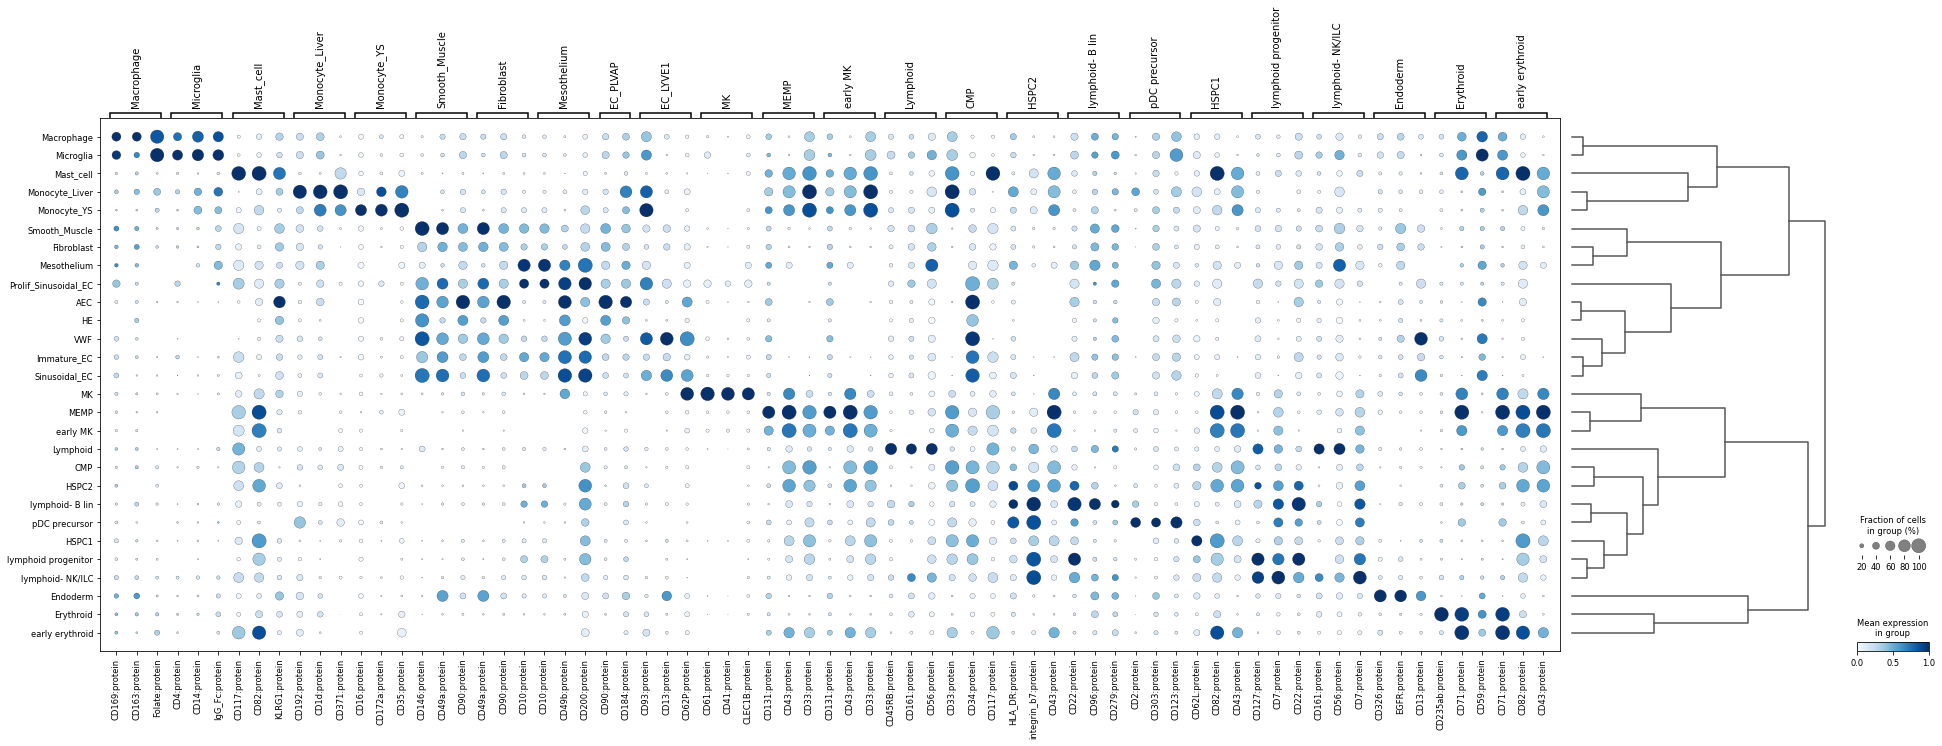

In [110]:
fig = sc.pl.dotplot(YS_DSB, var_names=curative_marker_list_3, cmap='Blues', use_raw=False, groupby='new_cell_labels_lvl2', standard_scale='var', dendrogram=True, return_fig=True)
fig.add_dendrogram(size=5).savefig('Sup_2a_hierarchial_dotplot.pdf')